In [1]:
from datasets.behavior import *
from common.utils import *
from common.plot_utils import *
from common.train_utils import *

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [3]:
BATCH_SIZE = 16

### Create dataset

In [4]:
dataset = BehaviourDataset('./behavior.csv', harmful_only=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# VAE

In [50]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(PCA_COMPONENTS, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 2)
        self.linear4 = nn.Linear(32, 2)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        mu =  self.linear3(x)
        sigma = self.linear4(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - sigma - 1/2).sum()
        return z

In [51]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(32, 64),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(64, 105),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [52]:
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

### Train VAE

In [53]:
EPOCHS = 40

In [54]:
vae_loss = train_model_vae(model, loader, optimizer, EPOCHS)

Epoch 1/40. time: 3.785s
train loss: 1.065570


Epoch 2/40. time: 3.519s
train loss: 0.645298


Epoch 3/40. time: 3.902s
train loss: 0.516463


Epoch 4/40. time: 3.988s
train loss: -1.947962


Epoch 5/40. time: 4.305s
train loss: -2.307949


Epoch 6/40. time: 4.051s
train loss: -2.349431


Epoch 7/40. time: 3.409s
train loss: -2.326554


Epoch 8/40. time: 3.999s
train loss: -2.447218


Epoch 9/40. time: 3.120s
train loss: -2.572683


Epoch 10/40. time: 2.913s
train loss: -2.427403


Epoch 11/40. time: 3.088s
train loss: -2.622466


Epoch 12/40. time: 3.472s
train loss: -2.485960


Epoch 13/40. time: 2.737s
train loss: -2.552552


Epoch 14/40. time: 2.789s
train loss: -2.582999


Epoch 15/40. time: 3.868s
train loss: -2.657810


Epoch 16/40. time: 4.047s
train loss: -2.518973


Epoch 17/40. time: 3.892s
train loss: -2.641045


Epoch 18/40. time: 3.647s
train loss: -2.493175


Epoch 19/40. time: 4.102s
train loss: -2.567317


Epoch 20/40. time: 4.114s
train loss: -2.582239


Epoch 21/40.

### Results

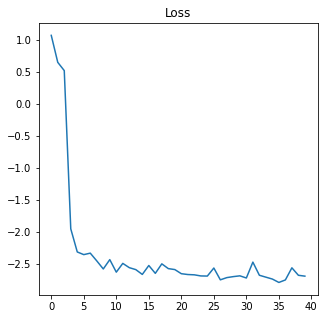

In [55]:
plot_train(vae_loss)

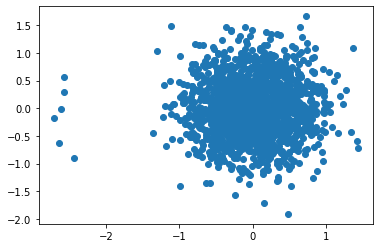

In [56]:
plot_latent(loader, model, False)

In [12]:
torch.save(model, './models/VAE_Behavior_40_epoch.pth')

# Metrics

In [57]:
from common.metrics import *
from torch.distributions import normal
import os

In [ ]:
model = torch.load('./models/VAE_Behavior_40_epoch.pth')
model.eval()

In [250]:
GEN_BATCH = 1024

In [263]:
distribution = normal.Normal(0.0, 1)
noize = distribution.sample([GEN_BATCH, 2])

In [264]:
with torch.no_grad():
    generated_behavior = model.decoder(noize)

In [ ]:
min_dist = behavior_dist(generated_behavior, loader)

In [169]:
print(f'min dist to real sample vector is {min_dist}')

min dist to real sample vector is 14.926982879638672


In [265]:
current_path = !pwd
clf_path = os.path.join(current_path[0], 'models/behavior_clf_40_epoch.pth')

In [266]:
probs = harmful_behavior_probs(generated_behavior, clf_path)

In [267]:
mean_prob = probs.mean()

In [268]:
print(f'mean classifier harmful behavior prob {mean_prob}')

mean classifier harmful behavior prob 0.45574116706848145


In [181]:
plt.rcParams['figure.figsize'] = [10, 7]

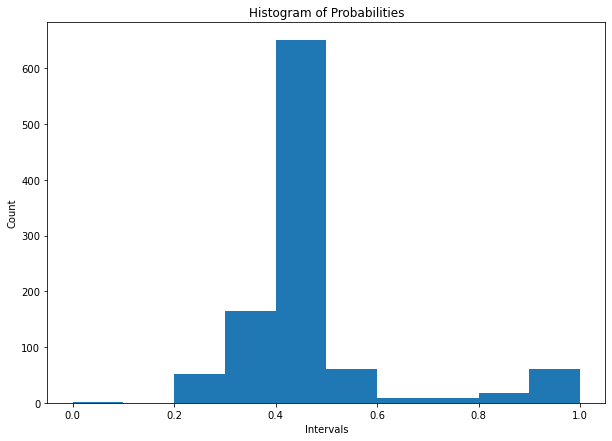

In [269]:
# Step 1: Convert probability values to floats
probabilities = [str(x.item()) for x in probs]
probabilities = [float(prob.replace(',', '.')) for prob in probabilities]

# Step 2: Create intervals from 0 to 1 with step size 0.1
intervals = [i / 10 for i in range(11)]

# Step 3: Count the values within each interval
counts = [0] * (len(intervals) - 1)
for prob in probabilities:
    for i in range(len(intervals) - 1):
        if intervals[i] <= prob < intervals[i + 1]:
            counts[i] += 1
            break

# Step 4: Plot the histogram
plt.bar(intervals[:-1], counts, align='edge', width=0.1)
plt.xlabel('Intervals')
plt.ylabel('Count')
plt.title('Histogram of Probabilities')
plt.show()